In [114]:
import argparse
import json
from pathlib import Path

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from scripts.lib import get_standards_characteristics, load_target_minerals, get_formula, load_images, load_standards_df

def get_variable_percent(formula, n, epsilon=.0001):
    elements = [
        {'element': e, 'min': m[0], 'max': m[1]}
        for e, m in formula.items()
    ]

    base = sum([e['min'] for e in elements])
    remainder = 1 - base
    element_remainders = [e['max'] - e['min'] for e in elements]

    v = np.hstack([
        np.random.uniform(0, e, (n, 1)) for e in element_remainders
    ])

    while remainder > 0:
        s = v.sum(axis=1, keepdims=True)
        v = (v/s)*remainder
        mask = v < element_remainders
        r = np.clip(v - element_remainders, 0, None)
        v = v - r
        v = v + (mask * (r.sum(axis=1) / mask.sum(axis=1)).reshape(-1, 1))
        if np.abs(remainder - v.sum(axis=1)).mean() < epsilon:
            break

    return [(e['element'], e['min']+v[:, i]) for i, e in enumerate(elements)]

def simulate_mineral(mineral, formula, standard_elements, n=5):
    if not isinstance(formula, list):
        formula = [formula]

    #elements = []
    #masses = []

    mineral_elements = {}
    def append(element, mass):
        if element in mineral_elements:
            mineral_elements[element] += mass
        else:
            mineral_elements[element] = mass

    for component in formula:
        if isinstance(component, str):
            for element, mass in get_formula(component, format="mass").items():
                append(element, np.ones(n)*mass)
        elif isinstance(component, dict):
            if 'quantity' in component:
                quantity = component['quantity']
                if isinstance(quantity, list):
                    quantity = np.random.randint(quantity[0], quantity[1]+1)
            else:
                quantity = 1

            for molecule, percent in get_variable_percent(component['components'], n):
                for element, mass in get_formula(molecule, format="mass").items():
                    append(element, percent*mass*quantity)
        else:
            raise ValueError(f"{str(component)} is not a recognized format")

    # Calculate mass percents
    df = pd.DataFrame(mineral_elements)
    df.columns = [f"{element}_mass" for element in df.columns]
    df['mass'] = df.sum(axis=1)
    for element in mineral_elements:
        df[f"{element}_percent"] = df[f"{element}_mass"]/df['mass']

    NOISE = 15
    STD = 1
    # Convert to intensities
    for element in standard_elements:
        e = standard_elements[element]
        df[element] = (
            e['intercept'] + np.clip(np.random.normal(scale=e['noise']*NOISE, size=n), 0, None)
        )

        if f"{element}_percent" in df:
            df[element] += (
                e['coef']*df[f"{element}_percent"] +
                np.random.normal(scale=e['std']*STD, size=n)
            )

        df[element] = np.clip(df[element], 0, None)


    '''mineral_elements = get_formula(component)
    for element, weight in mineral_elements.items():
        elements.append(element)
        masses.append(np.ones(n)*weight)'''

    df['mineral'] = mineral
    #df['formula'] = formula

    #return elements, masses
    return df





In [84]:
standards_dir = Path('challenge_data/dataset_1_opaques/standards/')
bits = 32
target_minerals_file = Path('challenge_data/dataset_1_opaques/target_minerals.yaml')
meteorite_dir = Path('challenge_data/dataset_1_opaques/obj1/')

characteristics = get_standards_characteristics(standards_dir, bits)

characteristics['P'] = {
    'element': 'P',
    'coef': 200.,
    'intercept': 0.0,
    'std': 10.,
    'noise': 1.
}

elements = list(characteristics.keys())

Loading standards...
Successfully loaded 10 standards with 8 masks

Loaded 29209 rows
Mineral counts:
{
    "NiS": 4644,
    "FeS": 4115,
    "SCOlv": 4043,
    "Fe3O4": 3969,
    "Fe": 3819,
    "rutile": 3607,
    "CaTiO3": 3470,
    "Ni": 1542
}


In [78]:
characteristics

{'Ca': {'element': 'Ca',
  'coef': 462.18178605580886,
  'intercept': 0.0,
  'std': 11.257305019123992,
  'noise': 0.7839330547100091},
 'Fe': {'element': 'Fe',
  'coef': 311.200762671983,
  'intercept': 0.0,
  'std': 12.186647205139565,
  'noise': 1.1155958908410433},
 'Mg': {'element': 'Mg',
  'coef': 840.6351519819596,
  'intercept': 0.0,
  'std': 13.785308695058687,
  'noise': 0.4296300849188238},
 'Ni': {'element': 'Ni',
  'coef': 302.78487023791786,
  'intercept': 0.0,
  'std': 14.881467710431,
  'noise': 1.329300610782891},
 'S': {'element': 'S',
  'coef': 210.33838378993957,
  'intercept': 0.0,
  'std': 8.65963719514509,
  'noise': 0.16686134572119973},
 'Si': {'element': 'Si',
  'coef': 1016.951679300757,
  'intercept': 0.0,
  'std': 12.817817389598144,
  'noise': 1.2343527334863311},
 'Ti': {'element': 'Ti',
  'coef': 1286.594667115852,
  'intercept': 0.0,
  'std': 21.114220834883863,
  'noise': 2.2062585039462057},
 'P': {'element': 'P',
  'coef': 200.0,
  'intercept': 0.0,


In [5]:
# Build model to predict standards

df = load_standards_df(standards_dir, 32)
#df = df[~df['mineral'].isin(['rutile', 'SCOlv'])]
#df = df[~df['mineral'].isin(['Fe'])][elements + ['mineral']]
unknown = pd.DataFrame(np.clip(
    np.hstack([
        np.random.uniform(-m, m, (10000, 1)) for m in df[elements].max(axis=0)
    ]), 0, None), columns=elements
)
unknown['mineral'] = 'Unknown'
df = pd.concat([df, unknown])


elements = list(characteristics.keys())
X = df[elements].values
Y = df['mineral']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

print("Training Classifier...")
#model = RandomForestClassifier(100, max_depth=10, n_jobs=-1)

# Worked very well! I Think!
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model = BaggingClassifier(
    model,
    n_estimators=100, 
    max_samples=.8, max_features=.5,
    n_jobs=-1
)
#from sklearn.mixture import GaussianMixture
#model = GaussianMixture(len(elements))
#model = RandomForestClassifier(5, max_depth=10, criterion='entropy')
'''model = BaggingClassifier(
    RandomForestClassifier(5, max_depth=10, criterion='entropy'), 
    #DecisionTreeClassifier(max_depth=10, criterion='entropy'),
    n_estimators=20, 
    max_samples=.8, #max_features=.5,
    n_jobs=-1
)
model = AdaBoostClassifier(model, n_estimators=5)'''
model.fit(X_train, Y_train)
print("Training Accuracy:", (model.predict(X_train) == Y_train).mean())
print("Testing Accuracy:", (model.predict(X_test) == Y_test).mean())

Loading standards...
Successfully loaded 10 standards with 8 masks

Loaded 29209 rows
Mineral counts:
{
    "NiS": 4644,
    "FeS": 4115,
    "SCOlv": 4043,
    "Fe3O4": 3969,
    "Fe": 3819,
    "rutile": 3607,
    "CaTiO3": 3470,
    "Ni": 1542
}
Training Classifier...


/home/docmario/miniconda3/envs/haiku/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


Training Accuracy: 0.9724232473618771
Testing Accuracy: 0.9758990053557766


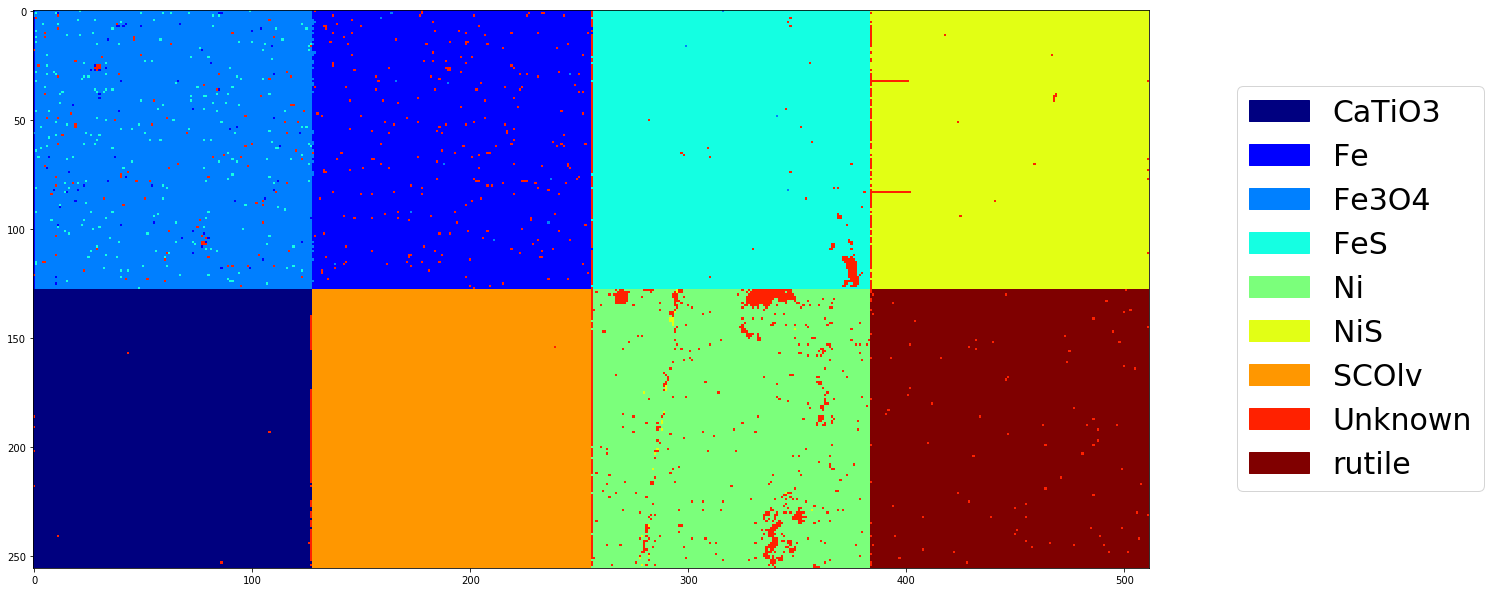

In [6]:
meteorite_df, meteorite_shape = load_images(standards_dir, bits)
x = meteorite_df[elements].values
meteorite_df['mineral'] = model.predict(x)
#print(meteorite_df.head(20))
minerals = sorted(meteorite_df['mineral'].unique())
results = meteorite_df.merge(
    pd.Series(
        minerals, name='mineral'
    ).reset_index().rename(columns={'index': 'mineral_index'}),
    on='mineral'
).sort_values('order')

figure, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(
    results['mineral_index'].values.reshape(meteorite_shape),
    cmap=plt.cm.get_cmap('jet', len(minerals))
)
colors = [im.cmap(im.norm(i)) for i in range(len(minerals))]
patches = [
    mpatches.Patch(
        color=colors[i], label=minerals[i]
    ) for i in range(len(minerals))
]
ax.legend(
    handles=patches, bbox_to_anchor=(1.3, .5, 0, 0),
    loc=5, borderaxespad=0., fontsize=30
)
#if title:
#    figure.suptitle(title, fontsize=30, y=.91)

In [54]:
unknown = pd.DataFrame(np.clip(
    np.hstack([
        np.clip(np.random.uniform(-2*m, m, (10000, 1)), 0, None) + np.random.normal(scale=30, size=(10000, 1))
        for m in df[elements].max(axis=0)
    ]), 0, None), columns=elements
)
unknown

,Ca,Fe,Mg,Ni,S,Si,Ti
0,160.692017,327.109697,1.056617,22.378914,46.531894,74.885987,3.973983
1,0.000000,114.335701,352.399770,0.000000,37.199408,71.162061,30.716707
2,66.806691,132.018815,284.833922,0.000000,0.000000,0.000000,193.585050
3,0.000000,0.000000,6.777241,18.567343,31.797313,0.000000,24.490289
4,121.900998,0.000000,0.000000,0.000000,57.443298,488.299083,157.262747
5,0.000000,57.114749,0.000000,19.539802,0.000000,0.000000,44.313484
6,0.000000,312.703695,200.419608,86.040502,101.425963,34.339103,7.507650
7,0.000000,16.740880,0.000000,84.876176,0.000000,0.000000,0.000000
8,12.868317,0.000000,363.524624,152.999811,0.000000,49.887040,0.000000
9,58.147891,143.537045,34.369494,21.277865,79.721771,29.618098,35.796072


In [49]:
characteristics

{'Ca': {'element': 'Ca',
  'coef': 462.18178605580886,
  'intercept': 0.0,
  'std': 11.257305019123992,
  'noise': 0.7839330547100091},
 'Fe': {'element': 'Fe',
  'coef': 311.200762671983,
  'intercept': 0.0,
  'std': 12.186647205139565,
  'noise': 1.1155958908410433},
 'Mg': {'element': 'Mg',
  'coef': 840.6351519819596,
  'intercept': 0.0,
  'std': 13.785308695058687,
  'noise': 0.4296300849188238},
 'Ni': {'element': 'Ni',
  'coef': 302.78487023791786,
  'intercept': 0.0,
  'std': 14.881467710431,
  'noise': 1.329300610782891},
 'S': {'element': 'S',
  'coef': 210.33838378993957,
  'intercept': 0.0,
  'std': 8.65963719514509,
  'noise': 0.16686134572119973},
 'Si': {'element': 'Si',
  'coef': 1016.951679300757,
  'intercept': 0.0,
  'std': 12.817817389598144,
  'noise': 1.2343527334863311},
 'Ti': {'element': 'Ti',
  'coef': 1286.594667115852,
  'intercept': 0.0,
  'std': 21.114220834883863,
  'noise': 2.2062585039462057},
 'P': {'element': 'P',
  'coef': 200.0,
  'intercept': 0.0,


In [121]:
# From targets file
n = 20000

target_minerals = load_target_minerals(target_minerals_file)
#target_minerals = load_target_minerals(Path('challenge_data/dataset_1_opaques/target_minerals_test.yaml'))
elements = list(characteristics.keys())
mineral_dfs = []
for mineral, formula in target_minerals.items():
    #print(mineral)

    df = simulate_mineral(mineral, formula, characteristics, 10000)
    #print(df.head())
    mineral_dfs.append(df[elements + ['mineral']])

df = pd.concat(mineral_dfs)

'''unknown = pd.DataFrame(np.clip(
    np.hstack([
        np.random.uniform(-2*m, m, (10000, 1)) for m in df[elements].max(axis=0)
    ]), 0, None), columns=elements
)'''

unknown = pd.DataFrame(np.clip(
    np.hstack([
        np.clip(np.random.uniform(-2*m, m, (n, 1)), 0, None) + np.random.normal(scale=50, size=(n, 1))
        for m in df[elements].max(axis=0)
    ]), 0, None), columns=elements
)
unknown['mineral'] = 'Unknown'
df = pd.concat([df, unknown])

X = df[elements].values
Y = df['mineral']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.8)

# Seems promising!
#from sklearn.neighbors import KNeighborsClassifier
#model = KNeighborsClassifier(50, weights='distance')

from sklearn.gaussian_process import GaussianProcessClassifier
#model = GaussianProcessClassifier(multi_class='one_vs_rest', copy_X_train=False)#n_jobs=1)

from sklearn.naive_bayes import GaussianNB
#model = GaussianNB()
'''model = BaggingClassifier(
    model,
    n_estimators=100, 
    max_samples=.9, max_features=.7,
    n_jobs=-1
)'''

from sklearn.svm import SVC
#model = SVC(max_iter=500)

'''model = BaggingClassifier(
    model,
    n_estimators=100, 
    max_samples=.8, max_features=.9,
    n_jobs=-1
)'''
#from sklearn.mixture import GaussianMixture
#model = GaussianMixture(len(elements))
model = RandomForestClassifier(50, max_depth=10, criterion='entropy', n_jobs=-1)
'''model = BaggingClassifier(
    RandomForestClassifier(5, max_depth=10, criterion='entropy'), 
    #DecisionTreeClassifier(max_depth=10, criterion='entropy'),
    n_estimators=20, 
    max_samples=.8, #max_features=.5,
    n_jobs=-1
)
model = AdaBoostClassifier(model, n_estimators=5)'''
model.fit(X_train, Y_train)
print("Training Accuracy:", (model.predict(X_train) == Y_train).mean())
print("Testing Accuracy:", (model.predict(X_test) == Y_test).mean())

Training Accuracy: 0.9439375
Testing Accuracy: 0.937203125


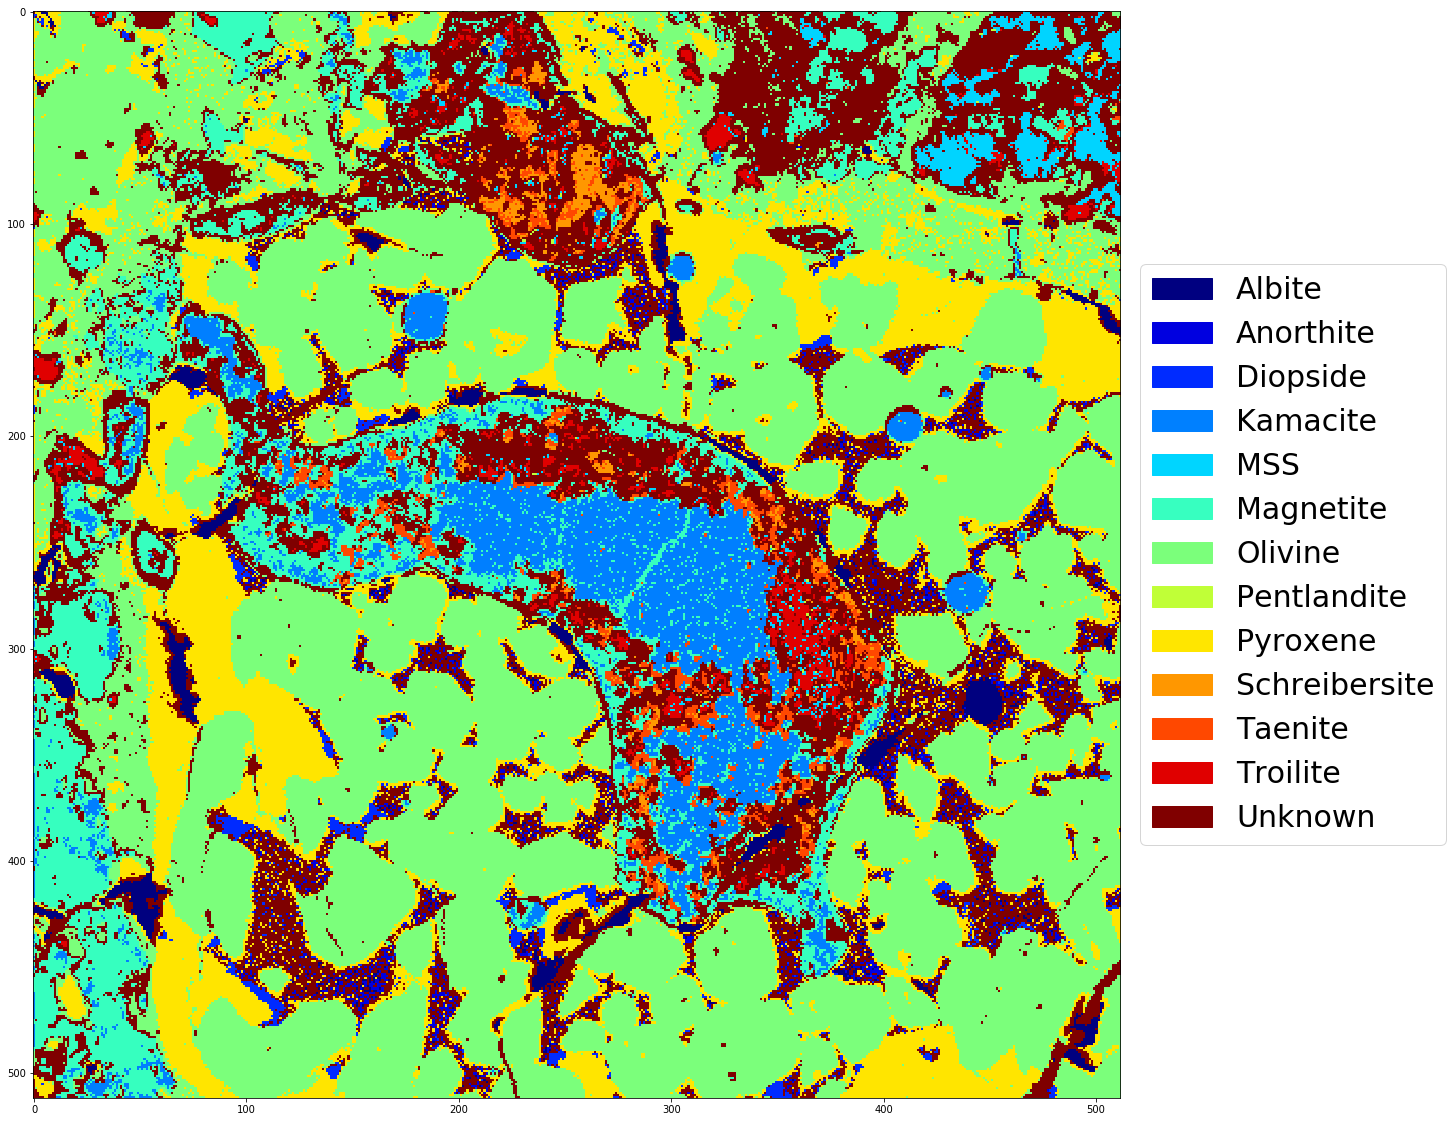

In [122]:
meteorite_df, meteorite_shape = load_images(meteorite_dir, bits)
x = meteorite_df[elements].values
meteorite_df['mineral'] = model.predict(x)
#print(meteorite_df.head(20))
minerals = sorted(meteorite_df['mineral'].unique())
results = meteorite_df.merge(
    pd.Series(
        minerals, name='mineral'
    ).reset_index().rename(columns={'index': 'mineral_index'}),
    on='mineral'
).sort_values('order')

figure, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(
    results['mineral_index'].values.reshape(meteorite_shape),
    cmap=plt.cm.get_cmap('jet', len(minerals))
)
colors = [im.cmap(im.norm(i)) for i in range(len(minerals))]
patches = [
    mpatches.Patch(
        color=colors[i], label=minerals[i]
    ) for i in range(len(minerals))
]
ax.legend(
    handles=patches, bbox_to_anchor=(1.3, .5, 0, 0),
    loc=5, borderaxespad=0., fontsize=30
)
#if title:
#    figure.suptitle(title, fontsize=30, y=.91)

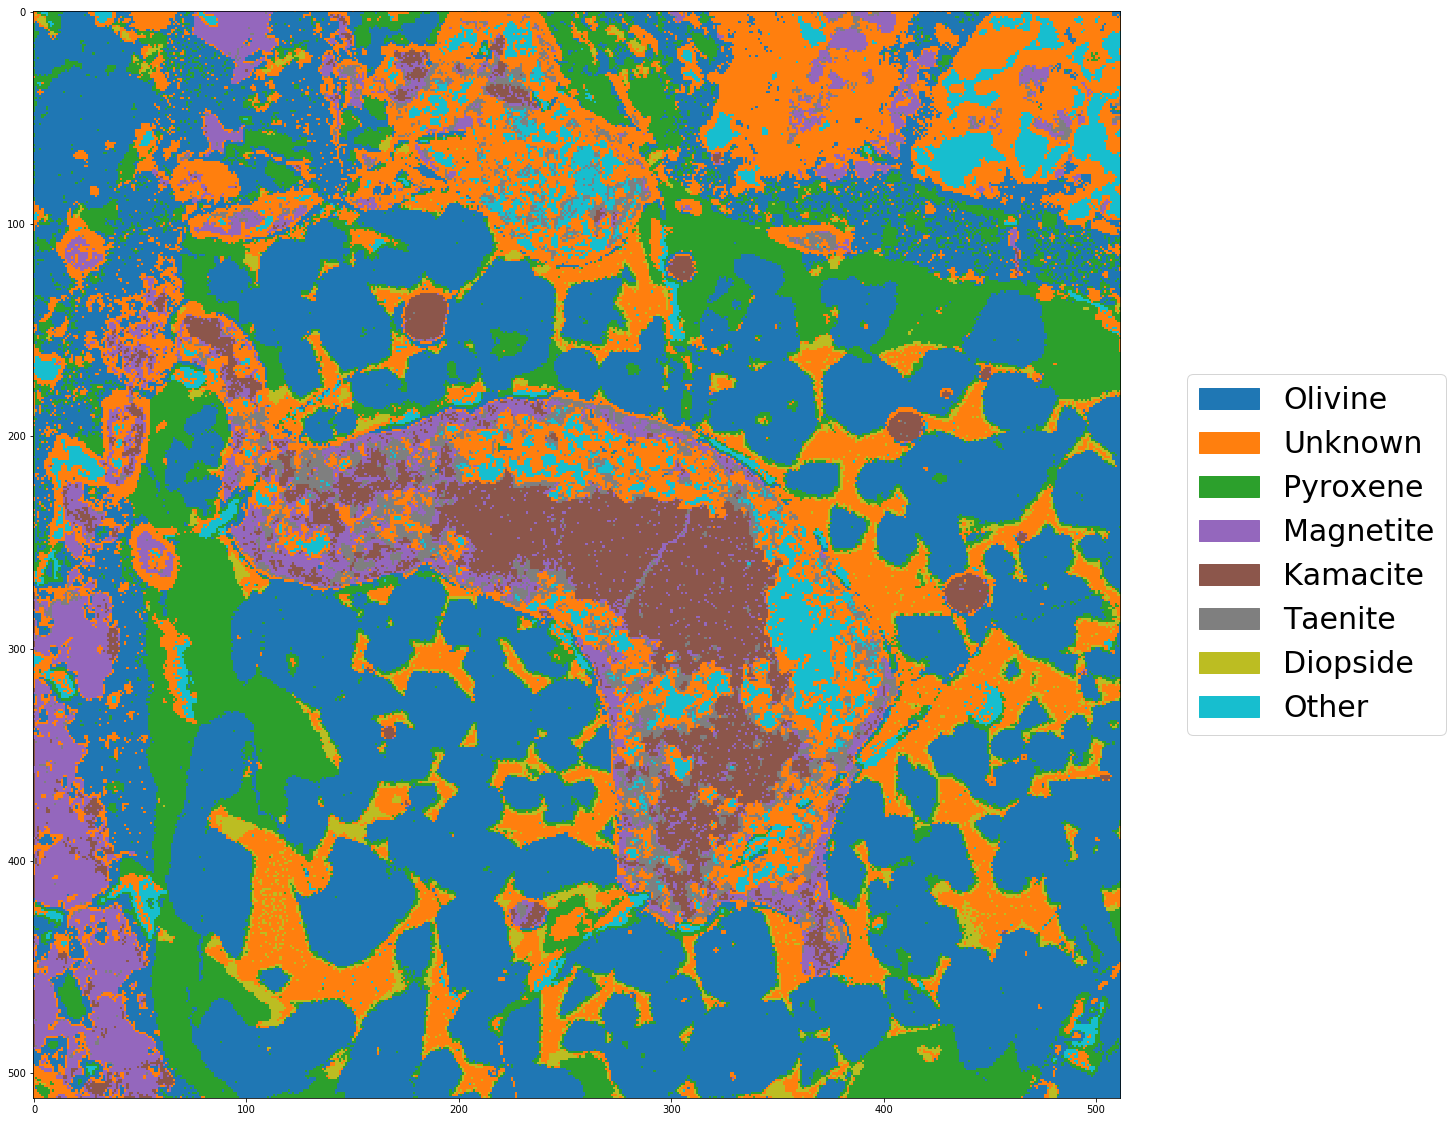

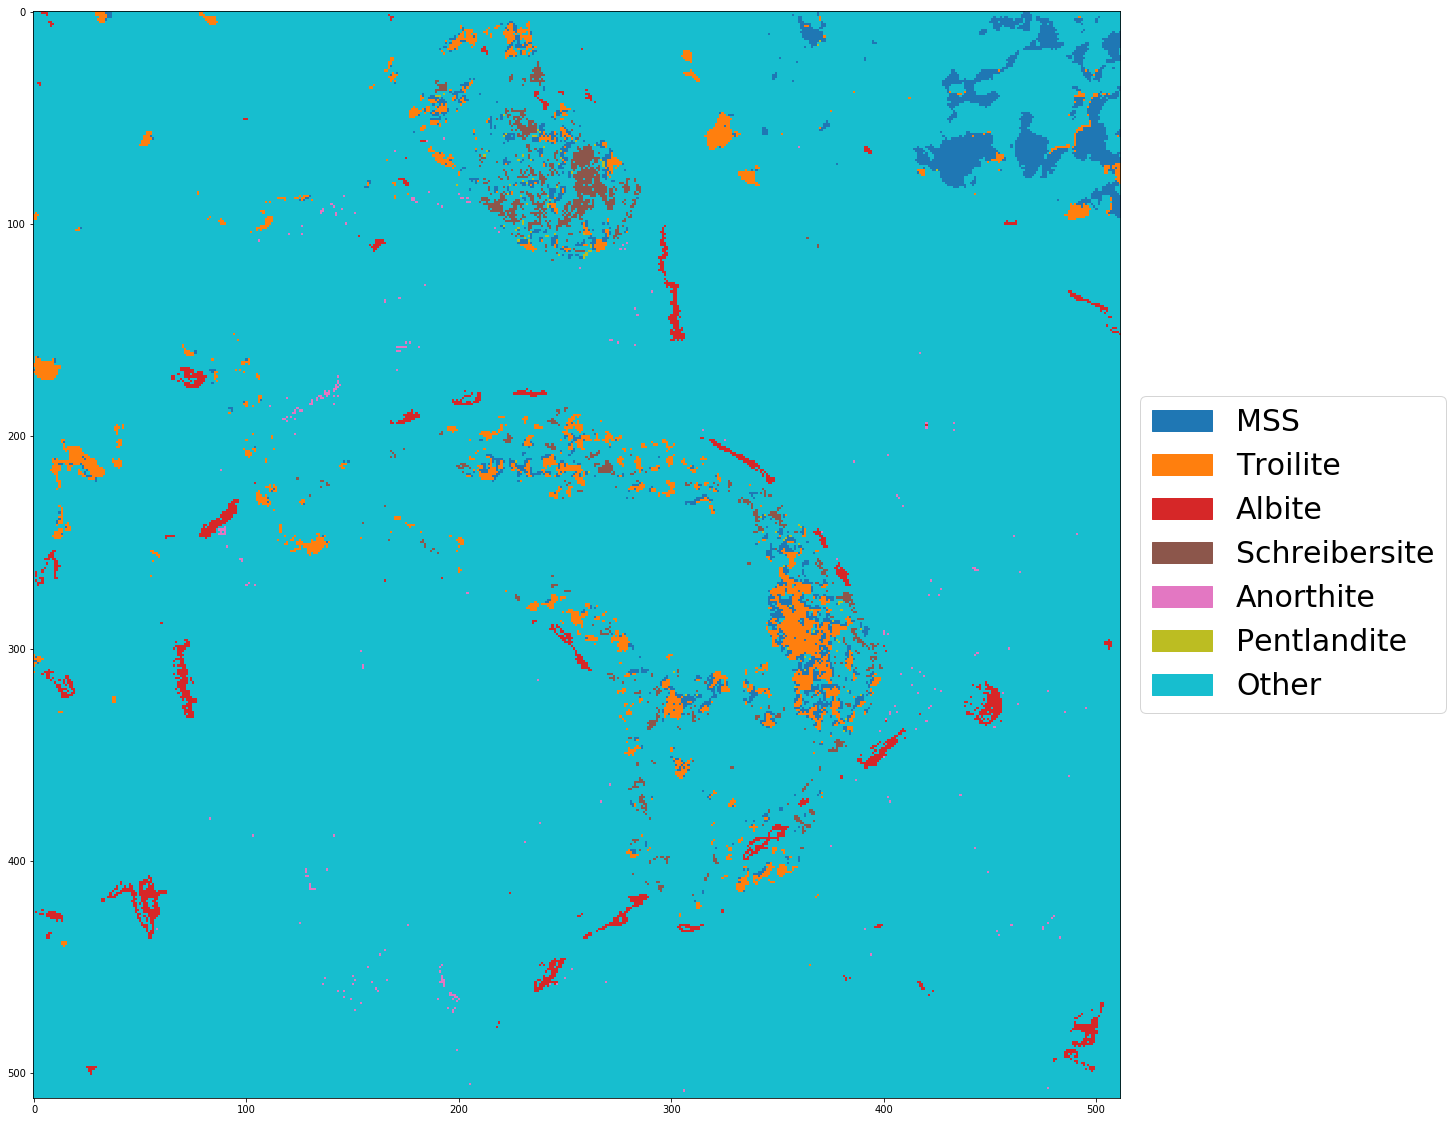

In [102]:
minerals = meteorite_df.groupby('mineral').count().sort_values('order', ascending=False).index
results = meteorite_df.merge(
    pd.Series(
        minerals, name='mineral'
    ).reset_index().rename(columns={'index': 'mineral_index'}),
    on='mineral'
).sort_values('order')

#results.groupby('mineral').count().sort_values('order', ascending=False).index

#np.array_split(

for msubset in np.array_split(minerals.tolist(), np.ceil(len(minerals)/10)):
    msubset = msubset.tolist() + ['Other']
    results['display'] = results.apply(
        lambda r: msubset.index(r['mineral']) if r['mineral'] in msubset else msubset.index('Other'),
        axis=1
    )
    
    figure, ax = plt.subplots(figsize=(20,20))
    im = ax.imshow(
        results['display'].values.reshape(meteorite_shape),
        cmap=plt.cm.get_cmap('tab10', len(msubset))
    )
    colors = [im.cmap(im.norm(i)) for i in range(len(msubset))]
    patches = [
        mpatches.Patch(
            color=colors[i], label=msubset[i]
        ) for i in range(len(msubset))
    ]
    ax.legend(
        handles=patches, bbox_to_anchor=(1.3, .5, 0, 0),
        loc=5, borderaxespad=0., fontsize=30
    )
    plt.show()

In [57]:
results[results['mineral'] == 'Schreibersite']['P'].mean()

8.089235569422778

In [36]:
results[(results['mineral'] == 'Schreibersite') & (results['P'] > 10)]['P'].std()

3.5830588700390047

In [35]:
14/100

0.14

In [41]:
results['P'].quantile(.999)

29.0

In [15]:
import periodictable
periodictable.formula('Fe1.5Ni1.5P').mass_fraction

{Fe: 0.41309270036904433, Ni: 0.43416268421238186, P: 0.15274461541857393}

In [17]:
characteristics

{'Ca': {'element': 'Ca',
  'coef': 462.18178605580886,
  'intercept': 0.0,
  'std': 11.257305019123992,
  'noise': 0.7839330547100091},
 'Fe': {'element': 'Fe',
  'coef': 311.200762671983,
  'intercept': 0.0,
  'std': 12.186647205139565,
  'noise': 1.1155958908410433},
 'Mg': {'element': 'Mg',
  'coef': 840.6351519819596,
  'intercept': 0.0,
  'std': 13.785308695058687,
  'noise': 0.4296300849188238},
 'Ni': {'element': 'Ni',
  'coef': 302.78487023791786,
  'intercept': 0.0,
  'std': 14.881467710431,
  'noise': 1.329300610782891},
 'S': {'element': 'S',
  'coef': 210.33838378993957,
  'intercept': 0.0,
  'std': 8.65963719514509,
  'noise': 0.16686134572119973},
 'Si': {'element': 'Si',
  'coef': 1016.951679300757,
  'intercept': 0.0,
  'std': 12.817817389598144,
  'noise': 1.2343527334863311},
 'Ti': {'element': 'Ti',
  'coef': 1286.594667115852,
  'intercept': 0.0,
  'std': 21.114220834883863,
  'noise': 2.2062585039462057}}

In [24]:
x = results[elements].values
proba = model.predict_proba(x)
proba

array([[2.74105377e-048, 1.68612259e-061, 1.11516566e-004, ...,
        1.19967938e-277, 2.56115986e-001, 1.57834159e-073],
       [4.26873467e-013, 1.88295457e-008, 6.86303285e-013, ...,
        1.10591655e-137, 7.48120942e-003, 2.18548212e-033],
       [5.47344914e-002, 6.81918655e-004, 7.15097471e-016, ...,
        1.86335158e-160, 3.59180767e-003, 2.20538762e-028],
       ...,
       [0.00000000e+000, 0.00000000e+000, 3.84617354e-052, ...,
        0.00000000e+000, 1.67397374e-002, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 3.85689257e-037, ...,
        0.00000000e+000, 6.61752576e-003, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 2.32181705e-035, ...,
        0.00000000e+000, 6.86225007e-003, 0.00000000e+000]])

In [21]:
results['P'].max()

106

In [25]:
(proba[results['mineral'] == 'Schreibersite'].mean(axis=0)*100).astype(int)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 90,  7,  0,  1,  0])

In [108]:
(proba[results['mineral'] == 'Albite'].mean(axis=0)*100).astype(int)

array([74, 15,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0])

In [109]:
(proba[results['mineral'] == 'Anorthite'].mean(axis=0)*100).astype(int)

array([20, 67,  3,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  5,  0])

In [110]:
(proba[results['mineral'] == 'Olivine'].mean(axis=0)*100).astype(int)

array([ 0,  0,  0,  0,  0,  0,  0, 76,  0,  2,  0,  0,  0, 19,  0])

In [36]:
np.array_split(minerals.tolist(), np.ceil(len(minerals)/10))

[array(['Olivine', 'Pyroxene', 'Magnetite', 'Unknown', 'Kamacite',
        'Albite', 'Schreibersite'], dtype='<U13'),
 array(['Anorthite', 'Diopside', 'Troilite', 'Pentlandite', 'Taenite',
        'MSS', 'Wollastonite'], dtype='<U13')]

In [23]:
results['mineral'].unique()

array(['Albite', 'Pyroxene', 'Olivine', 'Unknown', 'Troilite',
       'Magnetite', 'Anorthite', 'Taenite', 'Pentlandite',
       'Schreibersite', 'Diopside', 'Kamacite', 'MSS', 'Wollastonite'],
      dtype=object)

In [94]:
df[
    (df['mineral'] == 'Kamacite') & 
    (df['Ni'] < 10) &
    (df['Fe'].between(220, 250)) &
    
    (df['Ca'] < 10) &
    (df['Mg'] < 10) &
    (df['S'] < 10) &
    (df['Si'] < 10) &
    (df['Ti'] < 10)
]

,Ca,Fe,Mg,Ni,S,Si,Ti,mineral
1544,0.000000,245.849715,0.673118,7.858273,0.000000,0.173316,1.773233,Kamacite
3664,0.000000,248.794196,0.263206,0.000000,0.132469,1.922825,0.000000,Kamacite
4676,0.000000,249.624318,0.000000,5.464705,0.000000,0.000000,0.000000,Kamacite
5745,0.059050,244.410844,0.000000,8.576029,0.000000,1.998629,1.636945,Kamacite
6353,0.613602,248.115186,0.000000,0.000000,0.191497,0.000000,2.211895,Kamacite
7355,1.024550,249.628036,0.000000,0.000000,0.275159,0.353691,1.940684,Kamacite
8830,1.072282,244.388111,0.187322,9.943897,0.000000,0.238180,3.616631,Kamacite
9539,0.517998,244.680868,0.000000,6.937723,0.000000,0.000000,0.498195,Kamacite


In [93]:
df[
    (df['mineral'] == 'Unknown') & 
    (df['Ni'] < 10) &
    (df['Fe'].between(220, 250)) &
    
    (df['Ca'] < 10) &
    (df['Mg'] < 10) &
    (df['S'] < 10) &
    (df['Si'] < 10) &
    (df['Ti'] < 10)
]

,Ca,Fe,Mg,Ni,S,Si,Ti,mineral
63,0.000000,226.218822,0.000000,0.0,0.000000,0.0,0.000000,Unknown
324,0.000000,240.282950,0.000000,0.0,0.000000,0.0,0.000000,Unknown
670,0.000000,232.474870,0.000000,0.0,0.000000,0.0,0.000000,Unknown
685,0.000000,223.031787,0.000000,0.0,0.000000,0.0,0.000000,Unknown
1032,0.000000,244.148156,0.000000,0.0,0.000000,0.0,0.000000,Unknown
1254,0.000000,237.334513,0.000000,0.0,0.000000,0.0,0.000000,Unknown
1314,0.000000,227.577199,0.000000,0.0,0.000000,0.0,0.000000,Unknown
1824,0.000000,248.035336,0.000000,0.0,0.000000,0.0,7.460069,Unknown
1904,0.000000,244.680872,0.000000,0.0,0.000000,0.0,1.910192,Unknown
2038,0.000000,231.024881,0.000000,0.0,0.000000,0.0,0.000000,Unknown


In [87]:
meteorite_df

,order,Al,Ca,Cr,Fe,Mg,Ni,P,S,Si,Ti,mineral
0,0,0,0,6,292,0,3,0,0,4,11,Unknown
1,1,0,0,9,202,0,0,0,0,0,9,Unknown
2,2,0,0,9,205,0,0,3,0,0,6,Unknown
3,3,0,0,3,206,0,2,4,0,3,4,Unknown
4,4,2,0,7,210,0,2,0,0,0,8,Unknown
5,5,0,0,7,222,0,2,0,0,0,0,Kamacite
6,6,0,0,4,224,0,2,0,0,0,5,Kamacite
7,7,0,0,3,226,0,0,2,0,0,4,Kamacite
8,8,0,0,7,209,1,0,4,0,0,7,Unknown
9,9,0,0,6,251,0,2,0,0,0,3,Kamacite


In [84]:
proba = model.predict_proba(x)
proba

array([[1.61820484e-145, 2.75903674e-065, 2.09922557e-118, ...,
        8.18075383e-022, 8.59827640e-001, 2.41394580e-128],
       [6.03540986e-144, 2.44149126e-062, 4.84841611e-116, ...,
        1.88440072e-001, 5.13543210e-001, 1.51175737e-125],
       [8.15002217e-144, 2.61916856e-062, 1.00141662e-115, ...,
        1.89999934e-001, 3.17230334e-001, 4.83865452e-125],
       ...,
       [6.22003038e-130, 1.01179189e-053, 9.07642442e-106, ...,
        2.73947065e-064, 1.00000000e+000, 1.31638989e-113],
       [2.16537112e-131, 2.12436231e-055, 6.65452239e-105, ...,
        5.87617550e-066, 1.00000000e+000, 3.38822827e-115],
       [5.17833548e-132, 1.30985267e-052, 1.50884020e-104, ...,
        1.81550127e-066, 1.00000000e+000, 7.30186085e-112]])

In [89]:
proba[5:8]#.max(axis=1)

array([[1.67738903e-144, 4.12762641e-063, 2.83747432e-116,
        5.66847326e-001, 5.78535383e-055, 1.35294368e-001,
        1.27551425e-021, 5.95336776e-004, 1.06889344e-001,
        1.89999016e-001, 3.74610233e-004, 1.75468636e-125],
       [1.50223220e-144, 4.17170008e-063, 2.06120919e-116,
        5.83362774e-001, 5.74253148e-055, 1.08584447e-001,
        8.01122550e-022, 5.23981905e-004, 1.02049857e-001,
        1.89997043e-001, 1.54818982e-002, 1.02201778e-125],
       [8.92412528e-144, 2.60482318e-062, 1.33626448e-115,
        5.83740502e-001, 1.36287419e-055, 1.40252528e-001,
        2.76491285e-022, 5.00921775e-004, 8.40935759e-002,
        1.89998690e-001, 1.41378138e-003, 7.80430094e-125]])

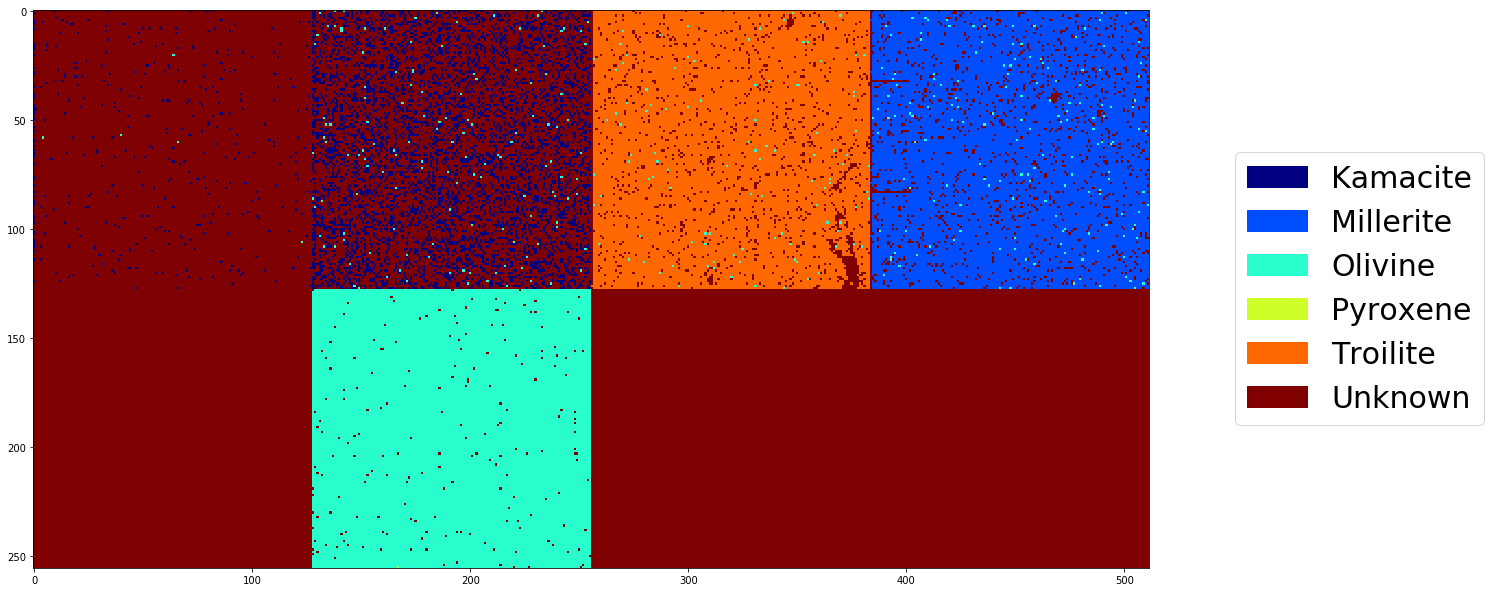

In [122]:
meteorite_df, meteorite_shape = load_images(standards_dir, bits)
x = meteorite_df[elements].values
meteorite_df['mineral'] = model.predict(x)
#print(meteorite_df.head(20))
minerals = sorted(meteorite_df['mineral'].unique())
results = meteorite_df.merge(
    pd.Series(
        minerals, name='mineral'
    ).reset_index().rename(columns={'index': 'mineral_index'}),
    on='mineral'
).sort_values('order')

figure, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(
    results['mineral_index'].values.reshape(meteorite_shape),
    cmap=plt.cm.get_cmap('jet', len(minerals))
)
colors = [im.cmap(im.norm(i)) for i in range(len(minerals))]
patches = [
    mpatches.Patch(
        color=colors[i], label=minerals[i]
    ) for i in range(len(minerals))
]
ax.legend(
    handles=patches, bbox_to_anchor=(1.3, .5, 0, 0),
    loc=5, borderaxespad=0., fontsize=30
)
#if title:
#    figure.suptitle(title, fontsize=30, y=.91)

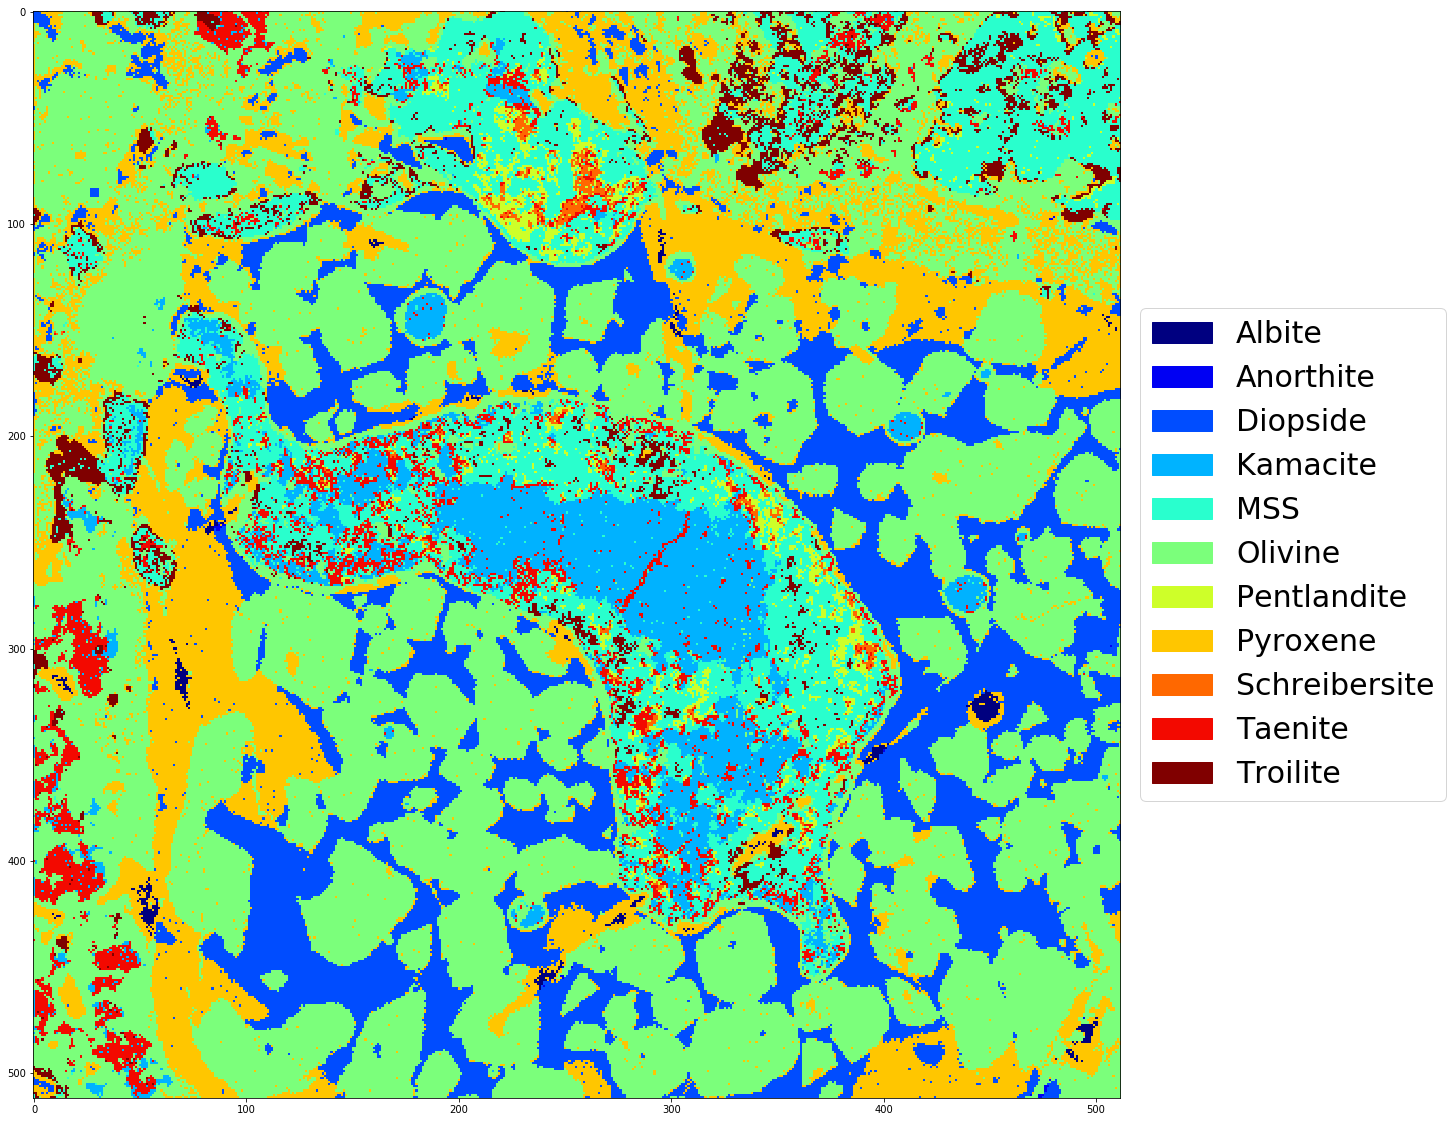

In [281]:
meteorite_df, meteorite_shape = load_images(meteorite_dir, bits)
x = meteorite_df[elements].values
meteorite_df['mineral'] = model.predict(x)
#print(meteorite_df.head(20))
minerals = sorted(meteorite_df['mineral'].unique())
results = meteorite_df.merge(
    pd.Series(
        minerals, name='mineral'
    ).reset_index().rename(columns={'index': 'mineral_index'}),
    on='mineral'
).sort_values('order')

figure, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(
    results['mineral_index'].values.reshape(meteorite_shape),
    cmap=plt.cm.get_cmap('jet', len(minerals))
)
colors = [im.cmap(im.norm(i)) for i in range(len(minerals))]
patches = [
    mpatches.Patch(
        color=colors[i], label=minerals[i]
    ) for i in range(len(minerals))
]
ax.legend(
    handles=patches, bbox_to_anchor=(1.3, .5, 0, 0),
    loc=5, borderaxespad=0., fontsize=30
)
#if title:
#    figure.suptitle(title, fontsize=30, y=.91)

In [282]:
model.predict_proba(x)

array([[0.00000000e+000, 0.00000000e+000, 1.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 1.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [6.35973223e-191, 2.45381210e-072, 1.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 2.48414715e-100],
       ...,
       [0.00000000e+000, 0.00000000e+000, 4.40406003e-067, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 9.84957529e-060, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 6.88896109e-079, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000]])

In [137]:
results[results['mineral'] == 'Pentlandite'][elements]

,Ca,Fe,Mg,Ni,S,Si,Ti
196056,2,115,0,8,45,72,6
196057,0,179,0,21,70,3,6
196058,2,168,0,41,66,2,0
196059,2,185,17,40,80,4,3
196060,6,175,6,18,13,82,4
196061,7,133,3,19,18,100,2
196062,0,110,3,23,34,114,4
196063,8,119,1,44,44,84,2
196064,0,118,3,18,32,91,2
196065,5,124,4,38,37,103,6


In [175]:
df[df['mineral'] == 'Pentlandite'].mean()

Ca      0.313786
Fe    118.624875
Mg      0.170135
Ni    121.301139
S      45.970638
Si      0.489542
Ti      0.899407
dtype: float64

In [221]:
from sklearn.cluster import KMeans
a = results[results['mineral'] == 'Unknown'][elements].values
k = KMeans(50)
k.fit(a)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [247]:
for i, row in pd.DataFrame(k.cluster_centers_, columns=elements).iterrows():
    d = {}
    for e in row.keys():
        #print(e, row[e])
        q = row[e]/characteristics[e]['coef']
        if q > .01:
            d[e] = q
    if ('S' in d):
        print(d['S'])
    if ('S' in d) and (np.abs(d['S'] - .33) < .15):
        print(i, (k.labels_ == i).sum(), d)
        #print(d['S'])

0.043254803278584594
0.01833905603867208
0.012945646062207657
0.010115068262674637
0.034271898082915114
0.07490625922809603
0.23560099903350615
11 2941 {'Fe': 0.48534187715002264, 'Ni': 0.12535678331092936, 'S': 0.23560099903350615, 'Si': 0.020019359756882377}
0.012791784134575502
0.06779637173405685
0.05287441167714017
0.04481676642729583
0.22702046320810942
27 3580 {'Fe': 0.5869659323508608, 'Ni': 0.040577697424273015, 'S': 0.22702046320810942, 'Si': 0.012293009493465429}
0.03333535566959529
0.01812236965913867
0.03395888574474639
0.04643851341626682
0.12013659400279436
0.023336779448422034
0.053612830692156915
0.027606244290874635
0.03765245739055029
0.018650257471274297
0.05559978878055042


In [259]:
from sklearn.cluster import KMeans
a = results[results['mineral'] == 'Unknown'][['S']].values
km = KMeans(50)
km.fit(a)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [260]:
labels = []

for i in range(len(km.cluster_centers_)):
    w = km.cluster_centers_[i]/characteristics['S']['coef']
    if (w > .25) and (w < .45):
        print(i, w)
        labels.append(i)

5 [0.31339572]
12 [0.38690902]
13 [0.27830156]
19 [0.34378537]
23 [0.26860072]
24 [0.28759519]
30 [0.44186503]
32 [0.25905969]
40 [0.36260057]
41 [0.2979747]
45 [0.32757834]


In [263]:
for i in labels:

    d = dict(results[results['mineral'] == 'Unknown'][elements].iloc[km.labels_ == i].mean())
    for k in d:
        d[k] = d[k]/characteristics[k]['coef']
    print([(e, m) for e,m in d.items() if m > .01])

[('Fe', 0.5423877753783481), ('Ni', 0.07641124932889268), ('S', 0.3133957185960041), ('Si', 0.017419602108530673)]
[('Fe', 0.5665445334879438), ('Ni', 0.07127772984449302), ('S', 0.3869090211470506), ('Si', 0.012962089005921926)]
[('Fe', 0.5289893044816136), ('Ni', 0.09148409555019807), ('S', 0.27830155839963167), ('Si', 0.02059463632962449)]
[('Fe', 0.5464839600821253), ('Ni', 0.07681453213768513), ('S', 0.343785366109694), ('Si', 0.0159221458695716)]
[('Fe', 0.5266962799716335), ('Ni', 0.08532235942412679), ('S', 0.26860072043027927), ('Si', 0.022058031978614577)]
[('Fe', 0.5313043138862245), ('Ni', 0.08748277784701668), ('S', 0.28759519115027554), ('Si', 0.020638602566537812)]
[('Fe', 0.6417268410213972), ('Mg', 0.023231733432347586), ('Ni', 0.018456124606644333), ('S', 0.4418650309845805), ('Si', 0.010411738836399762)]
[('Fe', 0.5227335197744251), ('Ni', 0.09516699440027582), ('S', 0.2590596879970779), ('Si', 0.021589208730079718)]
[('Fe', 0.5552201888999893), ('Mg', 0.010130588772

In [266]:
df[df['mineral'] == 'MSS'].mean()

Ca     0.306536
Fe    97.543105
Mg     0.170410
Ni    99.318002
S     75.339158
Si     0.509253
Ti     0.877796
dtype: float64

In [269]:
97 / characteristics['Fe']['coef'], 99 / characteristics['Ni']['coef'], 75 / characteristics['S']['coef']

(0.3116958942103929, 0.3269648180313938, 0.35656830031983555)

In [273]:
copy = df[df['mineral'] == 'MSS'].copy()
copy

,Ca,Fe,Mg,Ni,S,Si,Ti,mineral
0,0.176753,60.400341,0.103651,114.081034,84.815714,1.444787,0.000000,MSS
1,0.000000,171.100805,0.424332,9.117366,87.421690,0.000000,0.000000,MSS
2,0.000000,107.815181,0.344426,87.296592,76.874356,0.000000,5.040659,MSS
3,0.000000,89.672927,0.260223,101.558906,71.669939,0.455732,0.000000,MSS
4,0.000000,76.820742,0.197545,80.246762,76.202110,0.000000,0.000000,MSS
5,0.000000,62.867541,0.219865,98.389267,81.875464,0.000000,1.399031,MSS
6,0.711488,86.657158,0.432846,107.665924,70.037727,1.124953,1.655112,MSS
7,0.000000,95.481833,0.599723,98.571817,84.284818,0.517580,2.548344,MSS
8,0.331076,182.325949,0.000000,21.967955,64.666066,0.819071,0.000000,MSS
9,0.250140,101.500396,0.969272,124.638051,81.849988,0.692680,0.000000,MSS


In [274]:
copy['Fe_w'] = copy['Fe'] / characteristics['Fe']['coef']
copy['Ni_w'] = copy['Ni'] / characteristics['Ni']['coef']
copy['S_w'] = copy['S'] / characteristics['S']['coef']
copy

,Ca,Fe,Mg,Ni,S,Si,Ti,mineral,Fe_w,Ni_w,S_w
0,0.176753,60.400341,0.103651,114.081034,84.815714,1.444787,0.000000,MSS,0.194088,0.376773,0.403235
1,0.000000,171.100805,0.424332,9.117366,87.421690,0.000000,0.000000,MSS,0.549808,0.030112,0.415624
2,0.000000,107.815181,0.344426,87.296592,76.874356,0.000000,5.040659,MSS,0.346449,0.288312,0.365479
3,0.000000,89.672927,0.260223,101.558906,71.669939,0.455732,0.000000,MSS,0.288151,0.335416,0.340736
4,0.000000,76.820742,0.197545,80.246762,76.202110,0.000000,0.000000,MSS,0.246853,0.265029,0.362283
5,0.000000,62.867541,0.219865,98.389267,81.875464,0.000000,1.399031,MSS,0.202016,0.324948,0.389256
6,0.711488,86.657158,0.432846,107.665924,70.037727,1.124953,1.655112,MSS,0.278461,0.355586,0.332976
7,0.000000,95.481833,0.599723,98.571817,84.284818,0.517580,2.548344,MSS,0.306817,0.325551,0.400711
8,0.331076,182.325949,0.000000,21.967955,64.666066,0.819071,0.000000,MSS,0.585879,0.072553,0.307438
9,0.250140,101.500396,0.969272,124.638051,81.849988,0.692680,0.000000,MSS,0.326157,0.411639,0.389135


In [277]:
copy[copy['Fe_w'].between(.5, .6)]

,Ca,Fe,Mg,Ni,S,Si,Ti,mineral,Fe_w,Ni_w,S_w
1,0.000000,171.100805,0.424332,9.117366,87.421690,0.000000,0.000000,MSS,0.549808,0.030112,0.415624
8,0.331076,182.325949,0.000000,21.967955,64.666066,0.819071,0.000000,MSS,0.585879,0.072553,0.307438
32,1.370130,162.157785,0.000000,23.767449,78.614066,0.307186,0.000000,MSS,0.521071,0.078496,0.373750
39,0.237351,172.649426,0.018399,26.477649,62.629469,0.000000,1.891429,MSS,0.554785,0.087447,0.297756
44,0.000693,164.083935,0.409748,19.542816,69.283493,0.000000,0.000000,MSS,0.527261,0.064544,0.329391
46,1.281448,185.371907,0.142900,0.787915,87.115717,0.924796,0.000000,MSS,0.595667,0.002602,0.414169
48,0.320288,157.968711,0.129269,33.561638,78.770197,0.000000,2.729087,MSS,0.507610,0.110843,0.374493
60,0.871914,166.728275,0.000000,16.758604,96.380085,1.443008,4.931057,MSS,0.535758,0.055348,0.458214
68,0.000000,170.692021,0.000000,20.006275,88.725895,0.347674,0.000000,MSS,0.548495,0.066074,0.421825
76,0.547397,171.645932,0.143542,12.784257,62.778623,0.032984,0.703761,MSS,0.551560,0.042222,0.298465


In [235]:
periodictable.formula('48%wt Fe // 12%wt Ni // 23%wt S // 2%wt Si // O')

formula('Fe12.0701Ni2.87107S10.0728SiO13.1656')

In [212]:
#periodictable.formula('Fe2SO3').mass_fraction

{Fe: 0.5824674633852265, S: 0.167220155908741, O: 0.25031238070603257}

In [209]:
periodictable.formula('Mg2SiO3').mass_fraction

{Mg: 0.3898352523022414, Si: 0.2252359180936968, O: 0.3849288296040618}

In [207]:
periodictable.formula('Fe.9Ni.1').mass_fraction

{Fe: 0.8954328036566646, Ni: 0.10456719634333539}

In [195]:
import periodictable
periodictable.formula('Fe4.5Ni4.5S8').mass_fraction

{Fe: 0.32554549378529085, Ni: 0.342150091949818, S: 0.3323044142648911}

In [214]:
periodictable.formula('Ni9S8').mass_fraction

{Ni: 0.6731232429354889, S: 0.32687675706451114}

In [215]:
periodictable.formula('NiS').mass_fraction

{Ni: 0.6466993688738453, S: 0.35330063112615473}

In [197]:
periodictable.formula('CaMgSi2O6').mass_fraction

{Ca: 0.18507469854592742,
 Mg: 0.11223715125901407,
 Si: 0.25938996187492613,
 O: 0.4432981883201324}

In [227]:
periodictable.formula('(Mg1.6Fe.4)SiO4').mass_fraction

{Mg: 0.2536574802148079,
 Fe: 0.1457056365212502,
 Si: 0.1831952571634691,
 O: 0.4174416261004728}

In [192]:
characteristics

{'Ca': {'element': 'Ca',
  'coef': 462.18178605580886,
  'intercept': 0.0,
  'std': 11.257305019123992,
  'noise': 0.7839330547100091},
 'Fe': {'element': 'Fe',
  'coef': 311.200762671983,
  'intercept': 0.0,
  'std': 12.186647205139565,
  'noise': 1.1155958908410433},
 'Mg': {'element': 'Mg',
  'coef': 840.6351519819596,
  'intercept': 0.0,
  'std': 13.785308695058687,
  'noise': 0.4296300849188238},
 'Ni': {'element': 'Ni',
  'coef': 302.78487023791786,
  'intercept': 0.0,
  'std': 14.881467710431,
  'noise': 1.329300610782891},
 'S': {'element': 'S',
  'coef': 210.33838378993957,
  'intercept': 0.0,
  'std': 8.65963719514509,
  'noise': 0.16686134572119973},
 'Si': {'element': 'Si',
  'coef': 1016.951679300757,
  'intercept': 0.0,
  'std': 12.817817389598144,
  'noise': 1.2343527334863311},
 'Ti': {'element': 'Ti',
  'coef': 1286.594667115852,
  'intercept': 0.0,
  'std': 21.114220834883863,
  'noise': 2.2062585039462057}}

In [166]:
from sklearn.cluster import DBSCAN
d = DBSCAN(11)
a = results[results['mineral'] == 'Pentlandite'][elements].values
b = d.fit_predict(a)

In [167]:
for i in range(0, b.max()+1):
    print((b == i).sum())

31570
4
7
3
5
7
5
4
6
3


In [165]:
b

array([ 0,  0,  0, ..., -1,  0,  0])

In [148]:
len(d.components_)

32694

In [151]:
d.

array([    0,     1,     2, ..., 32694, 32695, 32696])